In [1]:
import sys
import os
sys.path.append("../src/whole_history_rating")
from whr import whole_history_rating
from whr import utils
from datetime import datetime
import datetime as dt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

from scipy.optimize import curve_fit

In [2]:
data_path = '../data/cfbd/games_1990_to_2020.csv'

In [3]:
games_df = pd.read_csv(data_path)
games_df_test = games_df[games_df.season<2015]
games_df_verify = games_df[games_df.season>=2015]
games_df.shape

(23256, 25)

In [4]:
datetime_from_cfbd = lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%S.%fZ")
mean_and_error = lambda x: (np.mean(x), np.std(x)/len(x))
abeError = lambda x: mean_and_error(np.abs(x))
date_from_cfbd = lambda x: datetime_from_cfbd(x).strftime('%Y-%m-%d')

In [5]:
def get_dates_df(df):
    date_dict = {}
    dates = df.start_date.to_numpy()
    dates_string = list(map(date_from_cfbd,dates))
    dates_string_list = []
    for date,date_string in zip(dates,dates_string):
        if date_string not in date_dict: 
            date_dict[date_string] = []
            dates_string_list.append(date_string)
        date_dict[date_string].append(date)
    return date_dict,dates_string_list

In [9]:
def iterate_by_day(df,whr,handicap=2.5, time_offset=10):
    date_dict,dates_string_list = get_dates_df(df)
    first_date = datetime_from_cfbd(date_dict[dates_string_list[0]][0])
    day_delta = 0
    for dates in dates_string_list:
        after_offset =  day_delta > time_offset
        print(after_offset, day_delta)
        #before day
        if after_offset: 
            whr.auto_iterate(time_limit = 10, precision = 10E-3)
        #middle day
        date_list = []
        for date in date_dict[dates]:
            current_date = datetime_from_cfbd(date)
            day_delta = (current_date-first_date).days

            games_day = df[df.start_date==date]
            date_list.append(games_day[['away_team','home_team','away_points','home_points', 'neutral_site']].to_numpy()[0])
        date_list = [[at,ht,ap,hp,day_delta,handicap*(1-ns)] for at,ht,ap,hp,ns in date_list]
        for game in date_list:
            whr.create_game(*game)
        #end day

In [10]:
def benchmark_w2(df, default_w2, verbose=False, time_offset=10, max_events=-1,popt=[]):
    n_games = games_df_test.shape[0]
    n_iter_games = 0
    n_pred_games = 0
    correct_prediction_list = []
    delta_mov_list = []
    pred_list = []
    mov_list = []
    
    scale = 16
    mov_SF = 16/scale
    whr = whole_history_rating.Base({'scale': scale,'w2':default_w2, 'debug':False})
    start_time = 0
    home_team_handicap = 2.5/13*scale
    current_day,day_delta=0,0
    
    iterate_by_day(df,whr)

    return correct_prediction_list,pred_list,mov_lis


In [11]:
start = time.perf_counter()
w2_list = []
per_corr_list = []
per_corr_unc_list = []
abe_list = []
abe_unc_list = []
mov_list_list = []
pred_mov_list_list = []
log_min, log_max = 2.6, 3.1
log_space = np.logspace(log_min, log_max,10)
lin_space = np.linspace(log_min, log_max,10)

popt = [1.05553551, 6.18054934]

for w2,w2_power in zip(log_space,lin_space):
    print("w2 value: {}, w2 power: {}".format(w2, w2_power))
    correct_prediction_list,pred_list,mov_list = benchmark_w2(games_df,w2,time_offset=100,max_events=100,popt=popt)
    mov_list,pred_list = np.asarray(mov_list),np.asarray(pred_list)
    mov_list_list.append(mov_list)
    pred_mov_list_list.append(pred_list)
    percent_corr,percent_corr_unc  = mean_and_error(correct_prediction_list)
    abe_error,abe_error_unc = abeError(mov_list-pred_list)
    w2_list.append(w2)
    per_corr_list.append(percent_corr)
    per_corr_unc_list.append(percent_corr_unc)
    abe_list.append(abe_error)
    abe_unc_list.append(abe_error_unc)
    mid_time = time.perf_counter()
    print("{:.2f}% corr, abe error: {:.2f}".format(percent_corr*100,abe_error))
    print("{:.2f} seconds elapsed".format(mid_time-start))
end = time.perf_counter()
end-start

w2 value: 398.1071705534973, w2 power: 2.6
False 0
False 0
False 5
False 6
False 7
True 11
True 13
True 18
True 20
True 27
True 34
True 41
True 48
True 55
True 62
True 64
True 68
True 69
True 76
True 83
True 88
True 89
True 90


AttributeError: bad adjusted gamma

In [ ]:
plt.errorbar(w2_list,abe_list,yerr=abe_unc_list)
plt.ylabel("absolute error")
plt.xlabel("w2")
plt.savefig("abe_v_w2_{}_to_{}.png".format(log_min, log_max))

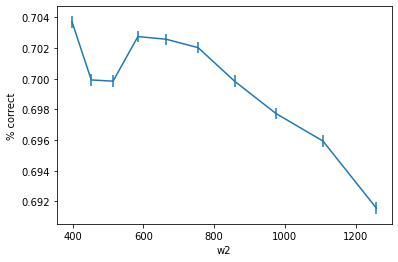

In [75]:
plt.errorbar(w2_list,per_corr_list,yerr=per_corr_unc_list)
plt.ylabel("% correct")
plt.xlabel("w2")
plt.savefig("percent_corr_v_w2_{}_to_{}.png".format(log_min, log_max))

In [76]:
def linear_func(x,m,b):
    return m * x + b

In [77]:
x,y = pred_mov_list_list[5],mov_list_list[5]
popt,pcov = curve_fit(linear_func,x,y)
popt, pcov

(array([1.13675681, 1.49557498]),
 array([[ 0.00360343, -0.01815795],
        [-0.01815795,  0.48608336]]))

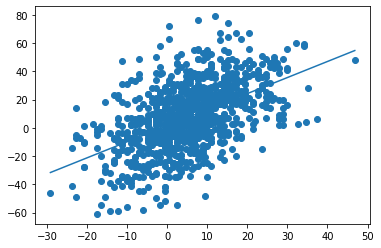

In [78]:
x_space = np.linspace(np.min(x), np.max(x),100)
y_pred = linear_func(x_space,*popt)
plt.scatter(x,y)
plt.plot(x_space,y_pred)

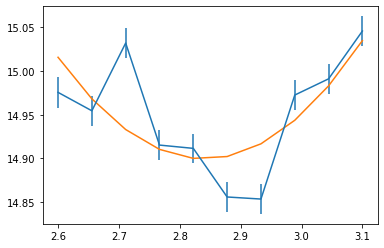

In [67]:
abes = []
abes_unc = []
for x,y, exp in zip(pred_mov_list_list,mov_list_list,lin_space):
    popt,pcov = curve_fit(linear_func,x,y)
    popt, pcov
    y_scaled = linear_func(x,*popt)
    abe,abe_unc = (abeError(y_scaled-y))
    abes.append(abe)
    abes_unc.append(abe_unc)
    
space = lin_space
plt.errorbar(space,abes,yerr=abes_unc)

def quadratic_func(x,a,b,c):
    return a * x **2 + b * x + c

popt,pconv = curve_fit(quadratic_func,space,abes)

y_pred = quadratic_func(space,*popt)
plt.plot(space,y_pred)

array([ 7.16020905e-07, -1.11718554e-03,  1.53323731e+01])

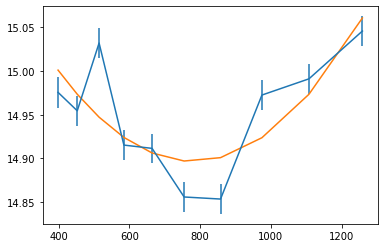

In [69]:
space = log_space
plt.errorbar(space,abes,yerr=abes_unc)

def quadratic_func(x,a,b,c):
    return a * x **2 + b * x + c

popt,pconv = curve_fit(quadratic_func,space,abes)

y_pred = quadratic_func(space,*popt)
plt.plot(space,y_pred)

popt

In [ ]:
max_events = [100,300,500]
total_time = [13.94,174,326.60867288500594]
plt.plot(max_events,total_time)

In [78]:
start_time=0
for i,row in games_df_test.iterrows():
        game_time = datetime_from_cfbd(row.start_date)
        if start_time == 0: start_time = game_time
        day_delta = (game_time-start_time).days
day_delta, day_delta/games_df_test.shape[0]

(8905, 0.4866386141319198)

In [79]:
.4866386141319198*1000

486.6386141319198

In [38]:
np.logspace(2.6, 3.1,10)

array([ 398.10717055,  452.43433466,  514.17518277,  584.34141337,
        664.08278506,  754.7059567 ,  857.69589859,  974.74022556,
       1107.75685051, 1258.92541179])